### import libs

In [1]:
# import scikit-allel
import allel
# check which version is installed
print(allel.__version__)
import pandas as pd
from scipy.spatial.distance import squareform
import seaborn as sns
import numpy as np

1.3.13


### import data

In [2]:
# vcf data
callset = allel.read_vcf('/data/proj2/home/students/a.nalakath/fg60_biallelic_snps.vcf.gz')
gt = allel.GenotypeArray(callset['calldata/GT'])

In [3]:
#callset['variants/POS']

In [4]:
# check
print(type(gt))

print(gt.shape)

<class 'allel.model.ndarray.GenotypeArray'>
(458599, 60, 2)


In [5]:
# for removing the extra dimension to this -(variants × samples × 1 → variants × samples)
gt_h = gt.haploidify_samples()

In [6]:
print(type(gt_h))

print(gt_h.shape[1])  # Number of haplotypes

<class 'allel.model.ndarray.HaplotypeArray'>
60


In [7]:
# this is to convert haplotype array back to genotype array
gt_hd = gt_h.to_genotypes(ploidy=1)

In [8]:
print(gt_hd.shape)

print(type(gt_hd))

(458599, 60, 1)
<class 'allel.model.ndarray.GenotypeArray'>


In [9]:
# to change genotype call into the number of non-reference alleles
gt_hd = gt_hd.to_n_alt()

In [10]:
gt_hd

array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], shape=(458599, 60), dtype=int8)

In [11]:
chroms = callset['variants/CHROM']
positions = callset['variants/POS']

### PCA

In [12]:
#Setting -1 to NaN
#Replacing NaNs with the mean allele count per SNP
X = np.array(gt_h, dtype=float)  # Converting her to NumPy array
X[X == -1] = np.nan  # Set missing data to NaN
# Replacing NaNs with mean per SNP
col_means = np.nanmean(X, axis=0)
inds = np.where(np.isnan(X))
X[inds] = np.take(col_means, inds[1])

/tmp/ipykernel_1338866/801097229.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X = np.array(gt_h, dtype=float)  # Converting her to NumPy array


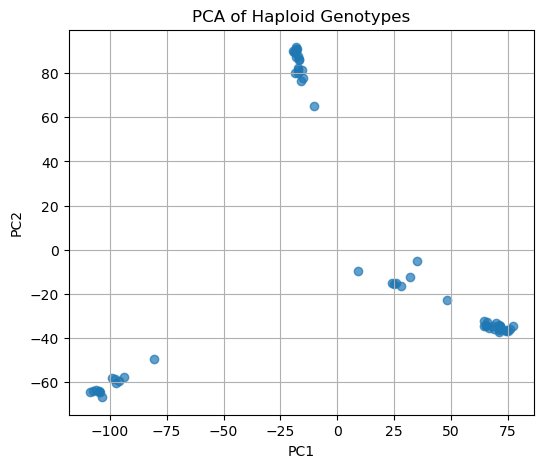

In [13]:
# PCA
from allel.stats.decomposition import GenotypePCA
from matplotlib import pyplot as plt

model = GenotypePCA(n_components=10, scaler=None)
model.fit(X)
coords = model.transform(X)

# Plot the first two PCs
plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Haploid Genotypes')
plt.grid(True)
plt.show()

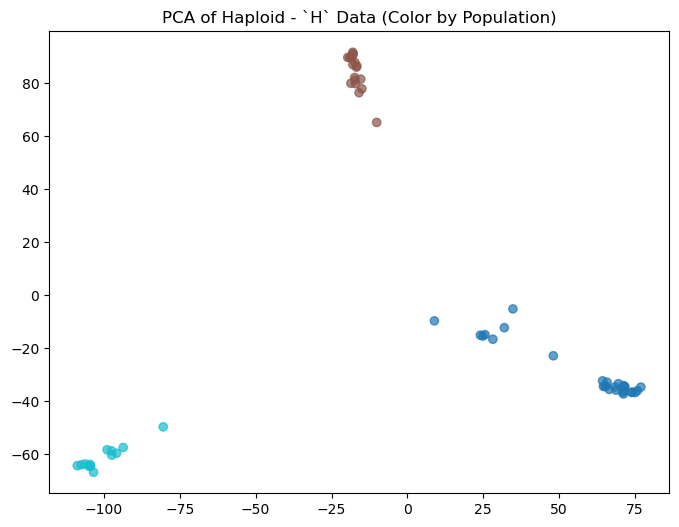

In [14]:
from sklearn.cluster import KMeans

K = 3
kmeans = KMeans(n_clusters=K, random_state=42)
labels = kmeans.fit_predict(coords)  # Assigns clusters to samples

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.title('PCA of Haploid - `H` Data (Color by Population)')
plt.show()

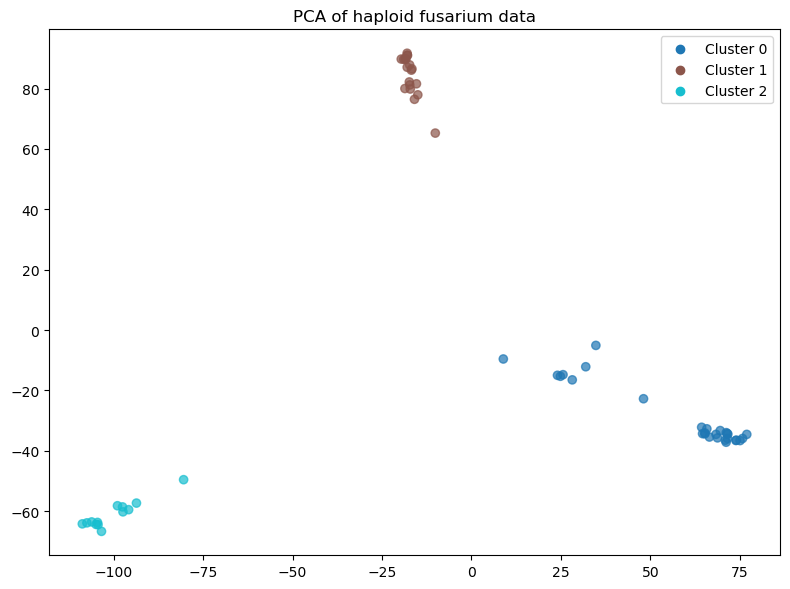

In [15]:
import numpy as np

plt.figure(figsize=(8, 6))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap='tab10', alpha=0.7)

# Get unique labels and their actual colors from the scatter plot
unique_labels = np.unique(labels)
colors = [scatter.cmap(scatter.norm(l)) for l in unique_labels]

# Build correct legend
for lbl, col in zip(unique_labels, colors):
    plt.scatter([], [], color=col, label=f'Cluster {lbl}')

plt.legend()
plt.title('PCA of haploid fusarium data')
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd

cluster_data = pd.DataFrame({'Sample': gt_h.shape[1], 'Cluster': labels})
cluster_data.to_csv('haplo_clusters_updated.csv', index=False)
cluster_data.head()

,Sample,Cluster
0,60,1
1,60,1
2,60,1
3,60,2
4,60,0


In [17]:
# Subset by cluster
gn0 = gt_h[:, labels == 0]
gn1 = gt_h[:, labels == 1]
gn2 = gt_h[:, labels == 2]

### Linkage disequillibrium

In [18]:
#r = allel.rogers_huff_r(gt_hd) ## between loci

In [19]:
# subsetting bcoz of huge size
## subset #1

In [20]:
gt_hd_sub = gt_h[:300]

In [21]:
r = allel.rogers_huff_r(gt_hd_sub)

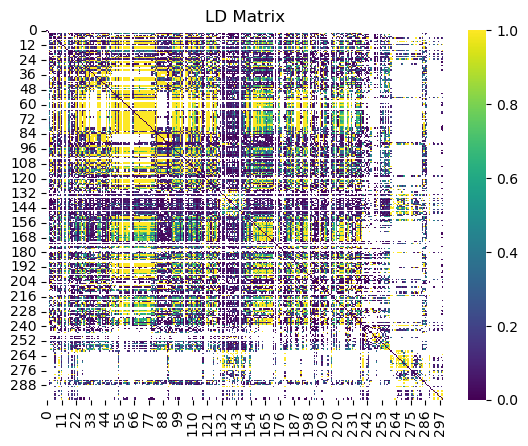

In [22]:
r2 = r ** 2
r2_matrix = squareform(r2)
sns.heatmap(r2_matrix, cmap='viridis')
plt.title('LD Matrix')
plt.show()

In [23]:
## subset #2

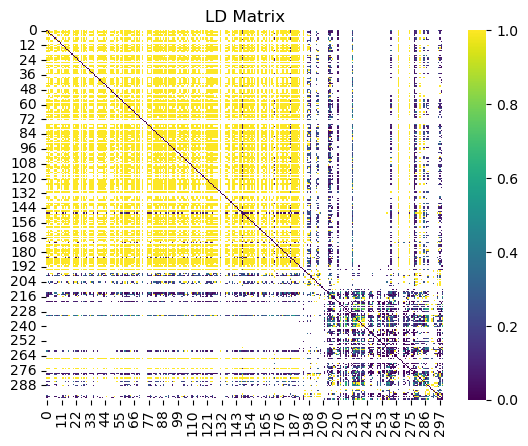

In [24]:
gt_hd_sub_2 = gt_h[300:600]
r_sub_2 = allel.rogers_huff_r(gt_hd_sub_2)
r2 = r_sub_2 ** 2
r2_matrix_2 = squareform(r2)
sns.heatmap(r2_matrix_2, cmap='viridis')
plt.title('LD Matrix')
plt.show()

<Axes: >

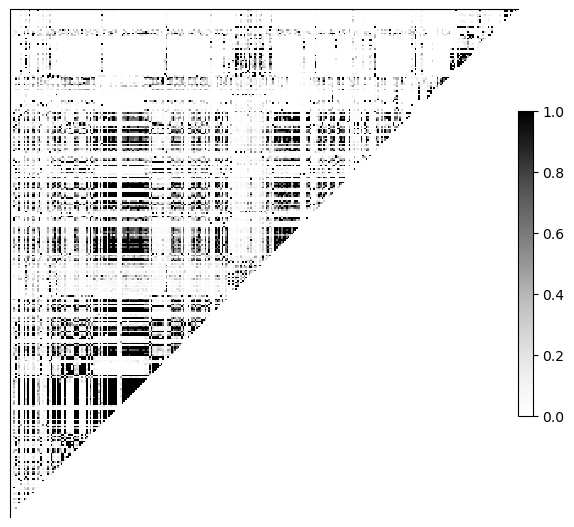

In [25]:
allel.plot_pairwise_ld(r2_matrix)

<Axes: >

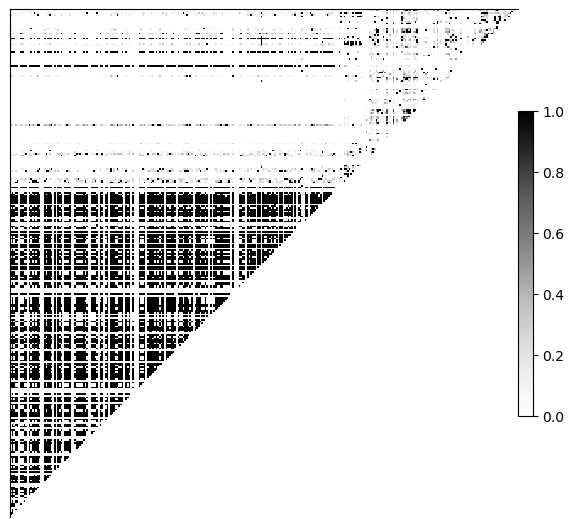

In [26]:
allel.plot_pairwise_ld(r2_matrix_2)

In [27]:
#print(type(r2_matrix))

print(r2_matrix)

[[ 0. nan nan ... nan nan nan]
 [nan  0. nan ... nan nan nan]
 [nan nan  0. ... nan nan nan]
 ...
 [nan nan nan ...  0. nan nan]
 [nan nan nan ... nan  0.  1.]
 [nan nan nan ... nan  1.  0.]]


## LD - whole genome
### windowed_r_squared function - scikit

In [28]:
import numpy as np
np.set_printoptions(threshold=np.inf)
#np.set_printoptions(threshold=1000)

In [29]:
pos = callset['variants/POS']
#pos

In [30]:
sort_idx = np.argsort(pos)
pos_sorted = pos[sort_idx]
gt_h_sorted = gt_h[sort_idx]

In [31]:
print(gt.shape)
print(gt_h.shape)
print(gt_hd.shape)

(458599, 60, 2)
(458599, 60)
(458599, 60)


In [32]:
r2, windows, counts = allel.windowed_r_squared(
    pos_sorted,
    gt_hd,
    size=4000,
    step=4000
)

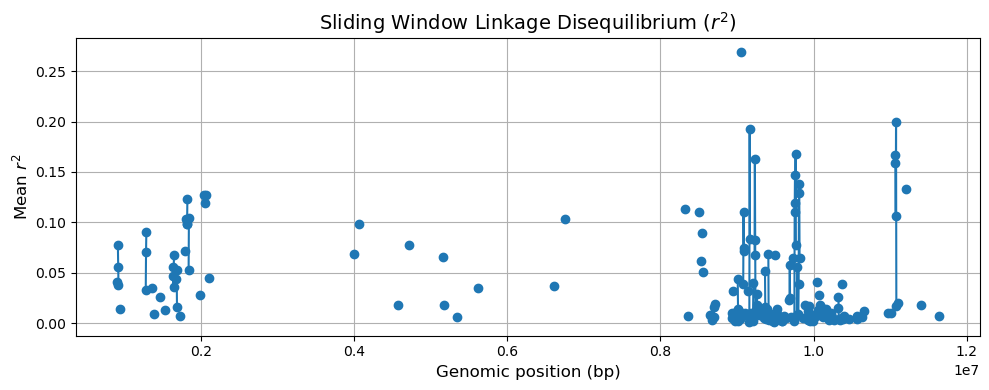

In [33]:
import matplotlib.pyplot as plt

# Midpoint of each window
midpoints = (windows[:, 0] + windows[:, 1]) / 2

# Plot
plt.figure(figsize=(10, 4))
plt.plot(midpoints, r2, marker='o', linestyle='-', linewidth=1.5)
plt.xlabel('Genomic position (bp)', fontsize=12)
plt.ylabel('Mean $r^2$', fontsize=12)
plt.title('Sliding Window Linkage Disequilibrium ($r^2$)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

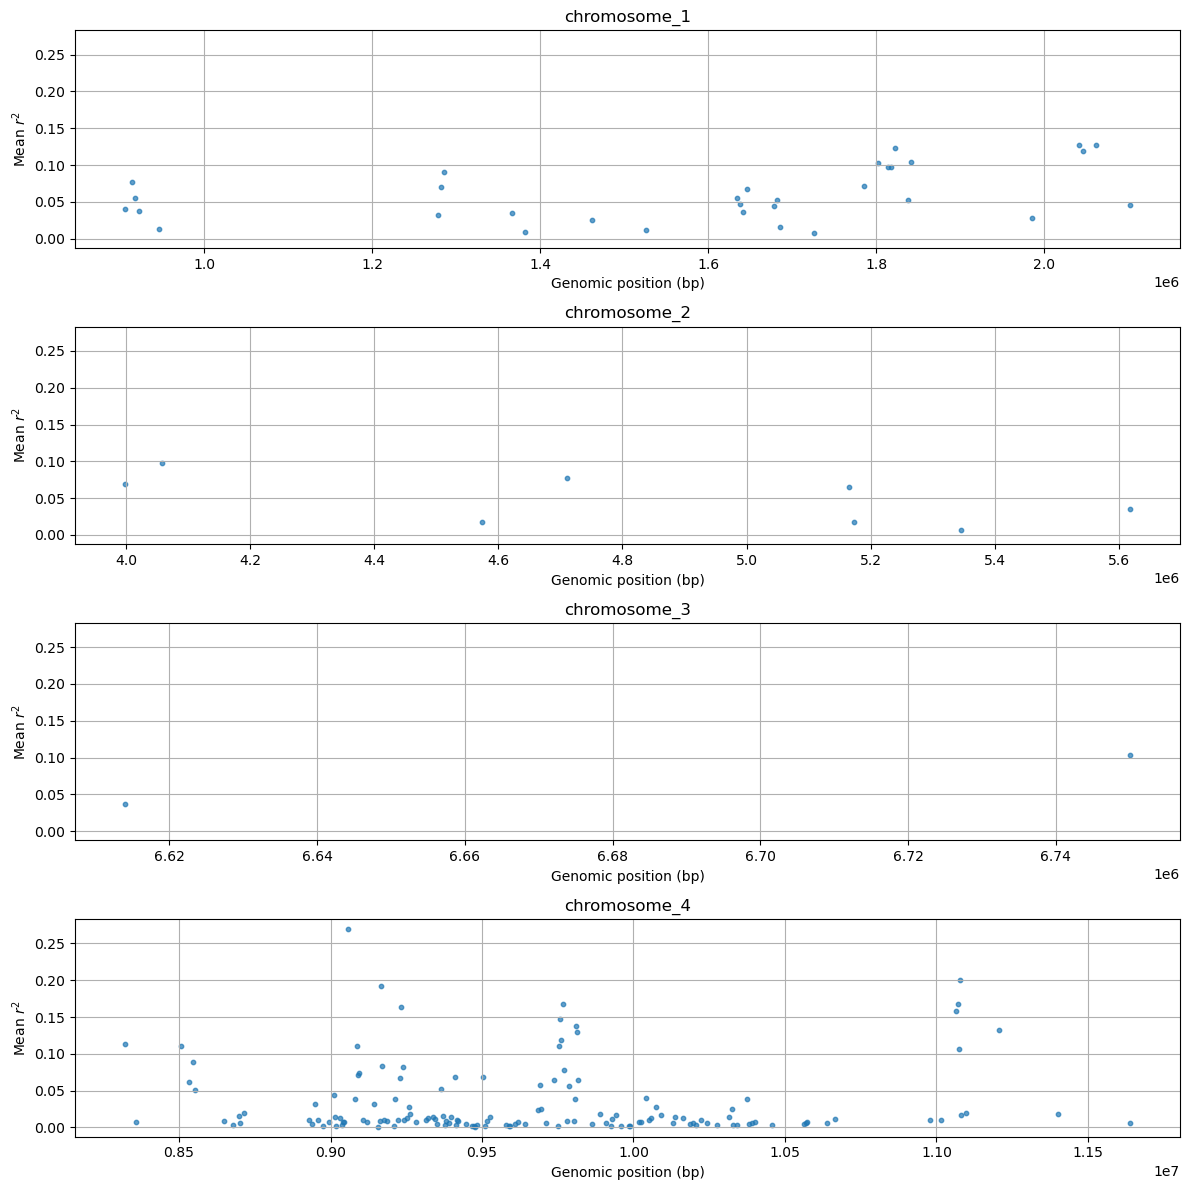

In [34]:
# Step 2: Compute windowed LD (r²)
r2, windows, counts = allel.windowed_r_squared(
    pos_sorted,
    gt_hd,
    size=4000,
    step=4000,
    fill=np.nan  # or 0 if you want to impute LD=0 in empty windows
)

# Step 3: Get window midpoints
midpoints = (windows[:, 0] + windows[:, 1]) / 2

# Get chromosome per window by midpoint lookup
window_chroms = np.array([
    chroms[np.searchsorted(pos_sorted, mid)] for mid in midpoints
])


import matplotlib.pyplot as plt
import numpy as np

chrom_list = np.unique(window_chroms)
fig, axs = plt.subplots(len(chrom_list), 1, figsize=(12, 3 * len(chrom_list)), sharey=True)

for i, chrom in enumerate(chrom_list):
    mask = window_chroms == chrom
    pos_chrom = midpoints[mask]
    r2_chrom = r2[mask]
    
    axs[i].scatter(pos_chrom, r2_chrom, s=10, alpha=0.7)
    axs[i].set_title(f'{chrom}', fontsize=12)
    axs[i].set_xlabel('Genomic position (bp)', fontsize=10)
    axs[i].set_ylabel('Mean $r^2$', fontsize=10)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1338866/2449348436.py:22: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x='Chromosome', y='r2', inner='box', cut=0, scale='width')


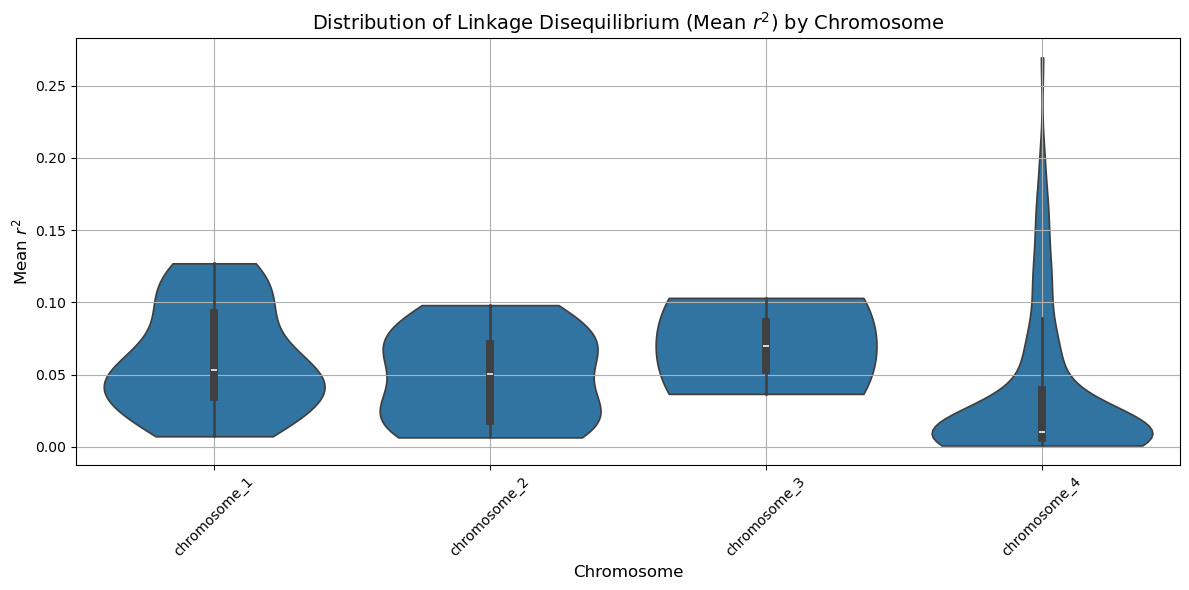

In [35]:
# --- Step 3: Compute window midpoints ---
midpoints = (windows[:, 0] + windows[:, 1]) / 2

# --- Step 4: Assign chromosome to each window ---
window_chroms = np.array([
    chroms[np.searchsorted(pos_sorted, mid)] for mid in midpoints
])

# --- Step 5: Create a DataFrame for plotting ---
df = pd.DataFrame({
    'Chromosome': window_chroms,
    'r2': r2,
    'counts': counts
})

# Optional: Filter out windows with low SNP count or NaN r²
df = df[df['counts'] >= 5]
df = df.dropna(subset=['r2'])

# --- Step 6: Plot box-and-whisker plot ---
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='Chromosome', y='r2', inner='box', cut=0, scale='width')
plt.ylabel('Mean $r^2$', fontsize=12)
plt.xlabel('Chromosome', fontsize=12)
plt.title('Distribution of Linkage Disequilibrium (Mean $r^2$) by Chromosome', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

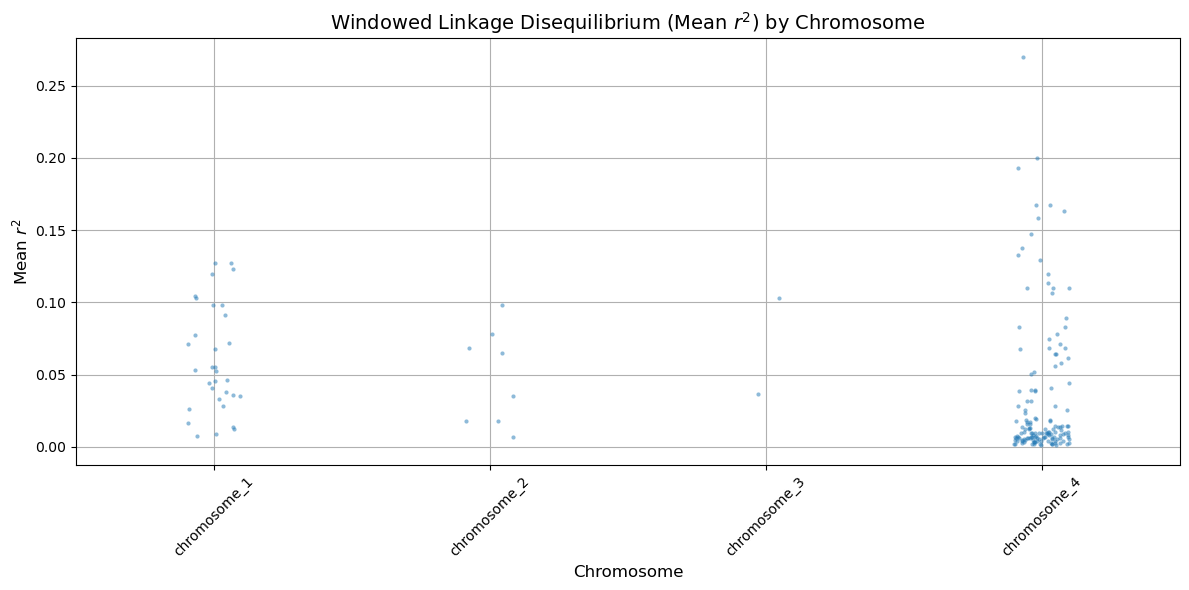

In [36]:
plt.figure(figsize=(12, 6))
sns.stripplot(data=df, x='Chromosome', y='r2', jitter=True, size=3, alpha=0.5)
plt.ylabel('Mean $r^2$', fontsize=12)
plt.xlabel('Chromosome', fontsize=12)
plt.title('Windowed Linkage Disequilibrium (Mean $r^2$) by Chromosome', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
genome_size = windows[-1, 1] - windows[0, 0]
print(f"Total genome span: {genome_size:,} bp")

Total genome span: 11,696,832 bp


In [38]:
#print(r2)

In [39]:
unique_chroms = np.unique(chroms)
unique_clusters = np.unique(cluster_data)

In [40]:
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import pandas as pd
import allel

cluster_r2_records = []

# Thresholds (adjust as needed)
min_variants = 2   # Lowered from 10
min_samples = 2    # Required for pairwise LD
window_size = 4000
step_size = 4000

for cluster_id in np.unique(labels):
    sample_mask = labels == cluster_id
    gt_cluster = gt_hd[:, sample_mask]

    for chrom in np.unique(chroms):
        snp_mask = chroms == chrom
        pos_sub = positions[snp_mask]
        gn_sub = gt_cluster[snp_mask]

        reason = None
        if gn_sub.shape[0] < min_variants:
            reason = "< min_variants"
        elif gn_sub.shape[1] < min_samples:
            reason = "< min_samples"
        elif pos_sub.size == 0:
            reason = "empty position array"
        elif np.all(np.isnan(gn_sub)):
            reason = "all genotypes are NaN"

        if reason:
            print(f"SKIP: Cluster {cluster_id}, {chrom} — {reason}")
            continue

        try:
            r2_vals, windows, counts = allel.windowed_r_squared(
                pos_sub, gn_sub, size=window_size, step=step_size
            )
        except Exception as e:
            print(f"ERROR: Cluster {cluster_id}, {chrom} — {str(e)}")
            continue

        for idx in range(len(r2_vals)):
            r2_val = r2_vals[idx]
            window_start, window_end = windows[idx]
            cluster_r2_records.append({
                'r2': r2_val,
                'cluster': f'Cluster {cluster_id}',
                'chromosome': chrom,
                'window_start': window_start,
                'window_end': window_end
            })

# Final dataframe
df_r2 = pd.DataFrame(cluster_r2_records)
df_r2['Group'] = df_r2['cluster'] + ' - ' + df_r2['chromosome']
df_r2['Group'] = pd.Categorical(df_r2['Group'], categories=sorted(df_r2['Group'].unique()), ordered=True)


ERROR: Cluster 0, chromosome_2 — index -1 is out of bounds for axis 0 with size 0
ERROR: Cluster 1, chromosome_2 — index -1 is out of bounds for axis 0 with size 0
ERROR: Cluster 2, chromosome_2 — index -1 is out of bounds for axis 0 with size 0


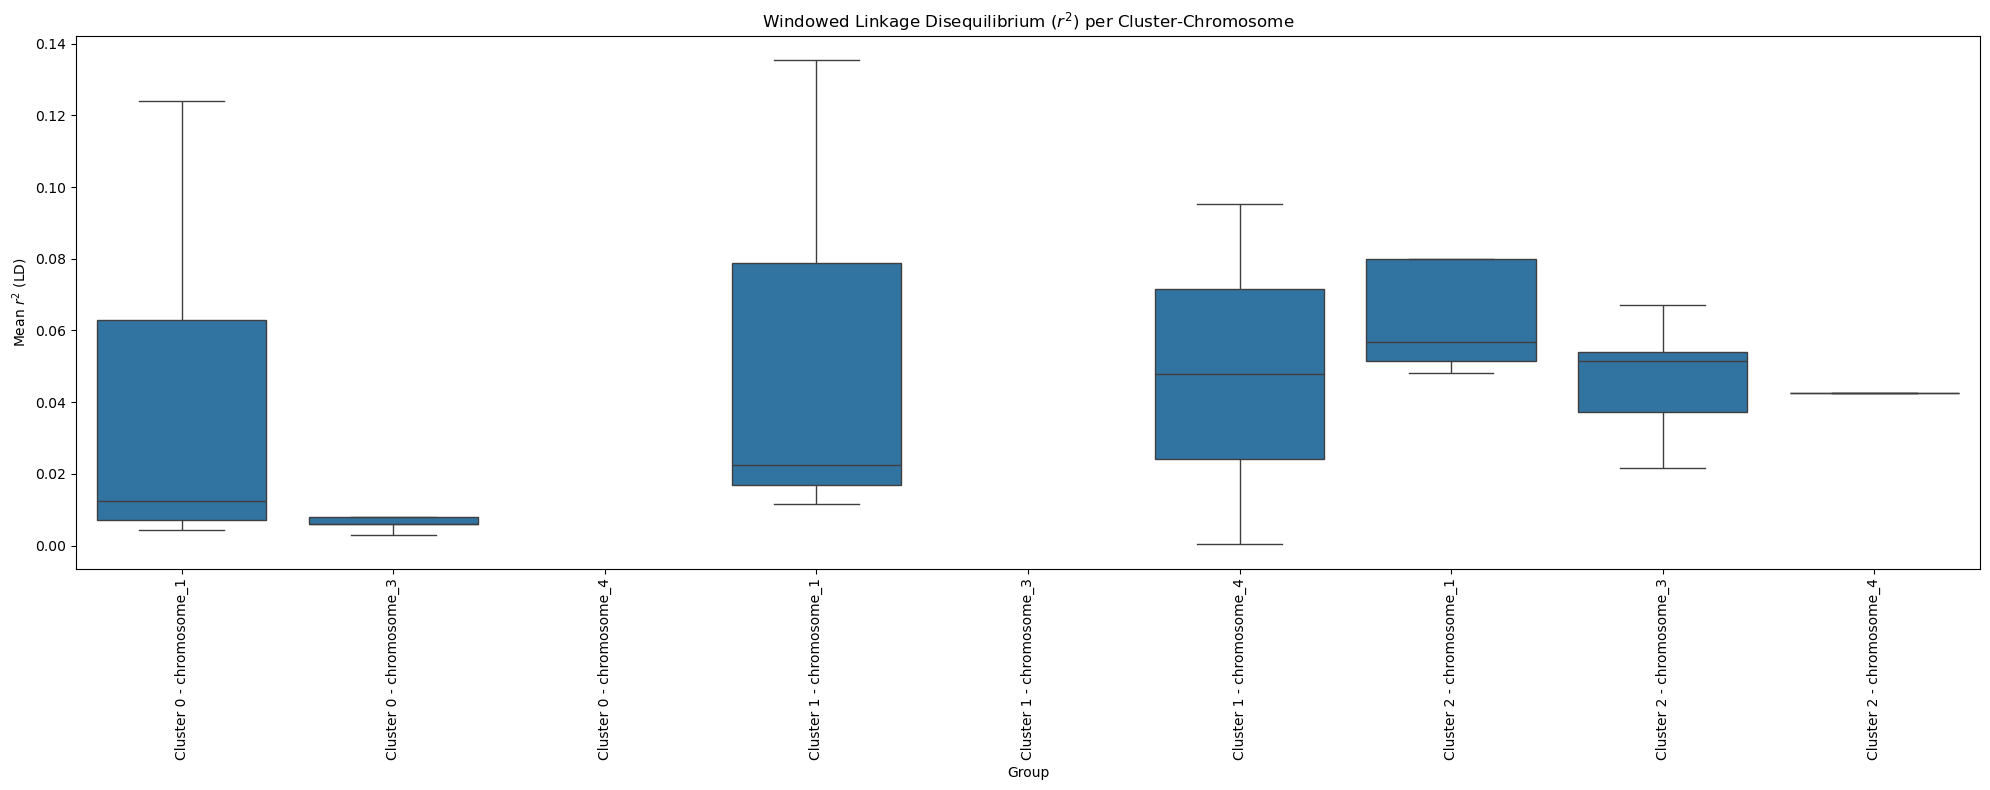

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure all expected combinations appear on the x-axis
from itertools import product

all_clusters = df_r2['cluster'].unique()
all_chroms = df_r2['chromosome'].unique()
all_expected = [f"{c} - {ch}" for c, ch in product(all_clusters, all_chroms)]

# Fill in missing combinations with NaN r2 values to preserve axis space
existing = set(df_r2['Group'].unique())
missing = set(all_expected) - existing

missing_rows = pd.DataFrame([{
    'r2': np.nan,
    'cluster': c,
    'chromosome': ch,
    'window_start': np.nan,
    'window_end': np.nan,
    'Group': f"{c} - {ch}"
} for c, ch in (g.split(" - ") for g in missing)])

df_r2 = pd.concat([df_r2, missing_rows], ignore_index=True)
df_r2['Group'] = pd.Categorical(df_r2['Group'], categories=sorted(all_expected), ordered=True)

# Plot
plt.figure(figsize=(20, 8))
sns.boxplot(data=df_r2, x='Group', y='r2', showfliers=False)
plt.xticks(rotation=90)
plt.ylabel('Mean $r^2$ (LD)')
plt.title('Windowed Linkage Disequilibrium ($r^2$) per Cluster-Chromosome')
plt.tight_layout()
plt.show()